In [ ]:
import torch
import numpy as np
import math

## Tensors

Tensors are the basic units of storage and computation in PyTorch. They are very similar to NumPy arrays, and follow the same syntax for indexing and for most arithmetic operations.


In [ ]:
# Basic tensor operations
x_tensor = torch.tensor([1, 2, 3, 4, 5])
y_tensor = torch.ones((2, 5))
prod = x_tensor * y_tensor[1,:]
print(prod, prod.shape) # Use .shape to view shape just as in NumPy

tensor([1., 2., 3., 4., 5.]) torch.Size([5])


In [ ]:
# Easy conversion between PyTorch and Numpy
x_numpy = np.array([1, 2, 3, 4, 5])
assert (x_tensor.numpy() == x_numpy).all()
assert (x_tensor == torch.from_numpy(x_numpy)).all()

What makes tensors **different** from NumPy arrays is:

1. They support GPU acceleration.
2. They contain additional information (accessed as attributes, which we will see later) which facilitate the easy building and training of neural networks, via **computation graphs** and **gradients**.

## A motivating example

To see the advantages of PyTorch in action, let's first take a look at how one might train a simple model using only NumPy:

In [ ]:
# Create 2000 random input and output data points
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# Step 0 - Initialization: Initialize model parameters (randomly, in this example)
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6
for t in range(2000):
    # Step 1 - Forward Pass: compute predicted y according to the following model:
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Step 2 - Compute Loss (MSE in this example)
    loss = np.square(y_pred - y).sum() # Sum across 2000 training points
    if t % 100 == 0:
        print(f'Epoch {t}: loss {loss}')

    # Step 3 - Differentiate: Use backprop (chain rule) to compute gradients
    # of the loss function with respect to a, b, c, d
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum() # Sum across 2000 training points
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Step 4 - Optimize: Update weights (vanilla GD in this example)
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

# From: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Epoch 0: loss 354519.8758933898
Epoch 100: loss 794.7239960893968
Epoch 200: loss 562.0635603527484
Epoch 300: loss 398.40542930583405
Epoch 400: loss 283.2420958591989
Epoch 500: loss 202.17610814954816
Epoch 600: loss 145.0936432014566
Epoch 700: loss 104.88693688840125
Epoch 800: loss 76.55876613193665
Epoch 900: loss 56.59439224594736
Epoch 1000: loss 42.52085684691431
Epoch 1100: loss 32.59759069446356
Epoch 1200: loss 25.599108283326906
Epoch 1300: loss 20.662312917805394
Epoch 1400: loss 17.179157079491223
Epoch 1500: loss 14.721156255060043
Epoch 1600: loss 12.986283710371358
Epoch 1700: loss 11.761597245134212
Epoch 1800: loss 10.89692866423157
Epoch 1900: loss 10.286355483284476
Result: y = 0.03376121343570352 + 0.8519525810646256 x + -0.005824371106675349 x^2 + -0.09264930046634844 x^3


Each step involved in training a model is coded very explicitly in this example:
0. Initialization: Initialize model parameters (i.e. weights)
1. Forward Pass: Compute predictions
2. Compute Loss
3. Differentiate: Compute gradients via backpropagation (chain rule)
4. Optimize: Update weights using gradients

Notice how:
- Every model parameter is stored as a variable, which contains a weight value to be continuously updated through training
- The calculation of the gradient of the loss function with respect to the model parameters is coded explicitly and thus *model dependent*
<!-- - The gradient of the loss function needs to be computed with respect to the model parameters explicitly using the chain rule -->
- Each model parameter's gradient is used to update the weight value according to a particular update rule which is also explicitly implemented - in this example, standard gradient descent (GD).

Steps 0 and 1 might not be so difficult using a basic package such as NumPy; however, one could imagine that steps 2 and 3 would quickly become too burdensome to implement manually for models with more parameters, both because of 1) the large number of parameters and 2) the fact that the explicit implementation of the chain rule and update rule will look different every time depending on the the model structure and optimization algorithm.

This is where PyTorch's **automatic differentiation** engine, **Autograd**, is useful. As the name implies, PyTorch can take care of computing gradients and applying optimization update rules automatically under the hood, such that the code we write to invoke these two operaations will look (very nearly) the same across all models.

## Computation Graphs and Autograd

<!-- Old paragraphs, commented out to preserve in case we want to bring back language -->
<!-- Autograd, PyTorch's automatic differentiation engine, is one of the best things that PyTorch has to offer when it comes to training neural networks! Recall that in order to compute gradients for weights in a neural network, you have to backpropagate errors at each node. This is computationally intensive even for a one or two layers and would be a nightmare to implement manually for very deep networks. -->
<!-- PyTorch tensors can keep track of a *computation graph* whenever operations are performed on/between tensors. Autograd performs backprop on this computation graph, so all the steps to compute the gradient are abstracted away. To perform a gradient step update, you simply have to call built-in PyTorch functions that computes the derivative of the loss and (if you're using gradient descent) takes a step toward a gradient of zero. -->

To implement automatic differentiation, PyTorch keeps track of a **computation graph** which logs every operation used to construct a certain output or mathematical expression (more on computation graphs in the [Appendix](#Appendix)). Computation graphs are created automatically whenever mathematical operations are performed using tensors as inputs. Using this graph, **Autograd** can perform backpropagation by repeated applications of the chain rule, and all of these differentiation steps are abstracted away from the user. To perform weight updates, we simply call built-in PyTorch optimizer functions which implement different update rules using the gradients computed during backpropagation.

As we work through the following example, keep in mind that computation graphs in PyTorch are *implicitly* constructed when one builds mathematical expressions. That is, one will never have to write code expressly for the purpose of building such a graph; rather, the computation graph will be assembled automatically using whichever Tensors or operations are appropriately "earmarked" for tracking (see `requires_grad` below).

## Demo #1

Let's start with a simple example of autograd.


In [ ]:
# Create tensors
x = torch.Tensor([2])
y = torch.Tensor([-1])
z = torch.Tensor([4])

print('x:', x)
print('y:', y)
print('z:', z)

x: tensor([2.])
y: tensor([-1.])
z: tensor([4.])


Tensors have a ```requires_grad``` field. When ```requires_grad == True``` for a certain tensor, any subsequent operations that this tensor is an input to will be incorporated into a computation graph. Autograd will then be able to automatically compute partial derivatives *with respect to this tensor*. (Derivative of what function? More on that [later](#step5).)

For any tensors which are the outputs of operations tracked in the computation graph, the ```grad_fn``` attribute will indicate the operation that created the tensor, represented as a `Function` object. (It is these `Function`s which encode the computation graph DAG [Directed Acyclic Graph].)

* If some starting tensors have requires_grad = True, then every tensor resulting from operations of those starting tensors will also have requires_grad = True.



In [ ]:
# By default, user created Tensors have ``requires_grad=False``
print('x and y requires_grad:', x.requires_grad, y.requires_grad)

a = (x + y) * z

# So you can't backprop through z
print('a grad_fn:', a.grad_fn)

x and y requires_grad: False False
a grad_fn: None


In [ ]:
# ``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad`` flag in-place.
# The input flag defaults to ``True`` if not given.
x = x.requires_grad_()
y = y.requires_grad_()
z = z.requires_grad_()

# a contains enough information to compute gradients, as we saw above
a = (x + y) * z
b = 0.5 * a
c = b**2
print(c)

tensor([4.], grad_fn=<PowBackward0>)


In [ ]:
print('a grad_fn:', a.grad_fn)
# If any input to an operation has ``requires_grad=True``, so will the output
print('a requires_grad:', a.requires_grad)

a grad_fn: <MulBackward0 object at 0x7f62e1fdbdc0>
a requires_grad: True


In pytorch, we use the ".backward()" function to calculate gradients.

* When we call "v.backward()" on the variable v, this means we are calculating the gradient of v, with respect to all other variables x that were used to compute v.  
* In other words, after calling v.backward(), then the variables x have the gradient $\frac{dv}{dx}$ stored in x.grad.

In [ ]:
# call .backward() on the variable that you want to calculate the gradient of
c.backward()

print('dc/dx: ', x.grad)
print('dc/dy: ', y.grad)
print('dc/dz: ', z.grad)

dc/dx:  tensor([8.])
dc/dy:  tensor([8.])
dc/dz:  tensor([2.])


Now that we've been introduced to `requires_grad`, `grad_fn` and the computation graph....

#### Question: Where should I actually set requires_grad to make everything work?
#### Short Answer: In any tensors which represent model parameters or weights.

Long Answer:

- If you are initializing a parameter(s)/weight(s) by creating an individual tensor(s) manually, you have to set its `requires_grad = True` argument.
- If you are initializing a parameter(s)/weight(s) by using built-in PyTorch methods from packages such as nn.Layer and nn.Parameter, the internally initialized tensors should already have `requires_grad` set to `True`.


## GPU Acceleration

GPUs are built for parallel processing — they can handle thousands of operations at the same time — which makes them great for computationally-intensive neural nets.

In [ ]:
# To run tensor operations on GPU in Colab, go to Edit -> Notebook settings -> and select GPU as the hardware accelerator.
# If GPU is enabled, the following assertion should pass.
assert torch.cuda.is_available()

In [ ]:
# When creating a tensor, set its device to use CUDA (a GPU parallel computing platform), as shown below.
# What this means is that we are telling PyTorch to physically initialize the relevant
# variable in GPU memory.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = torch.rand(5, 5, device=device)
y = torch.rand(5, 5, device=device)
x * y

tensor([[0.4832, 0.0665, 0.0197, 0.2763, 0.1252],
        [0.1414, 0.0459, 0.0023, 0.0138, 0.3642],
        [0.0625, 0.0554, 0.1053, 0.2693, 0.3180],
        [0.2612, 0.0769, 0.2709, 0.1622, 0.0142],
        [0.0058, 0.0308, 0.0354, 0.6303, 0.2456]], device='cuda:0')

# Training a Neural Network on CIFAR-10

In this part, we will train a neural network to perform multi-class classifications on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 32x32 images belonging to 10 classes.

In particular, we will train a fully-connected neural network with 1 hidden layer and a ReLU activation function.



## Step 1: Load the Dataset

We use helper functions from the torchvision.datasets library to load the CIFAR-10 dataset.

In [ ]:
## Download CIFAR-10 dataset

import torch
import torchvision
import torchvision.transforms as transforms

# A transformation applied to the images of the dataset
# Update the data to tensors and normalize their values by setting the mean and std dev
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./part_2_data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./part_2_data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./part_2_data/cifar-10-python.tar.gz to ./part_2_data
Files already downloaded and verified


In [ ]:
ex_img, ex_label = trainset[30]

In [ ]:
import matplotlib.pyplot as plt

def display_img(im):
  t1 = np.swapaxes(im, 0, 2)
  t2 = np.swapaxes(t1, 0, 1)
  plt.imshow(t2)

plane


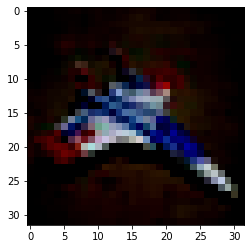

In [ ]:
print(classes[ex_label])
display_img(ex_img)

### torch DataLoaders

[DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) support iterating through a pytorch dataset.  They are initialized with two relevant arguments:
* `batch_size`: the number of data-points that the dataloader outputs during each iteration
* `shuffle`: if true, the dataloader returns the dataset in a different order each time that you iterate through it.

In [ ]:
# Define dataloaders

batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

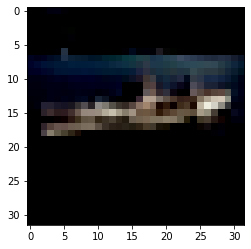

In [ ]:
for x, y in trainloader:
  display_img(x[0])
  break

## 2. Define the model

We use the torch.nn package to define our model as a sequence of layers.  The pytorch library has already [defined their own classes](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) for most types of layers and activation functions.  You can use these torch classes as "building blocks" to specify the architecture of your own neural network.

Defining a model typically involves implementing two functions:
* init(self, -): initialize python classes corresponding to each layer (and activation function) for the network.
* forward(self, x): specifies the order in which each layer is applied to the input to calculate the forward pass on input x.

Note that you *do not* need to implement your own backward function! - torch automatically constructs a computational graph (which implicitly specifies how to compute the backward pass) from your forward pass code.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print('image shape: ', ex_img.shape)

input_dim = ex_img.shape[0] * ex_img.shape[1] * ex_img.shape[2]
print('input dim: ', input_dim)

hidden_layer_dim = 100
num_classes = len(classes)

image shape:  torch.Size([3, 32, 32])
input dim:  3072


In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
      super(MyNeuralNetwork, self).__init__()

      self.hidden_layer = nn.Linear(input_dim, hidden_layer_dim)
      self.relu = nn.ReLU()
      self.output_layer = nn.Linear(hidden_layer_dim, num_classes)

    def forward(self, x):
      o1 = self.hidden_layer(x)
      o2 = self.relu(o1)
      o3 = self.output_layer(o2)
      return o3

In [ ]:
ex_img.shape

torch.Size([3, 32, 32])

In [ ]:
model = MyNeuralNetwork()

sm = torch.nn.Softmax(dim = 1)

b_pred = model.forward(ex_img.reshape(1, -1))
yhat_pred = sm(b_pred)

In [ ]:
yhat_pred

tensor([[0.1092, 0.1044, 0.0983, 0.0809, 0.1165, 0.0862, 0.1049, 0.0948, 0.0989,
         0.1060]], grad_fn=<SoftmaxBackward0>)

In [ ]:
model.hidden_layer.weight

Parameter containing:
tensor([[ 1.7521e-02, -1.2595e-02, -1.3309e-02,  ..., -5.9593e-03,
          1.5547e-02,  1.2579e-02],
        [ 3.2433e-04,  3.9255e-03, -9.5559e-04,  ..., -1.3419e-02,
         -9.6976e-03,  9.3373e-03],
        [-1.0370e-02, -1.5703e-02, -9.1657e-03,  ...,  9.4230e-03,
         -8.3546e-03, -7.8710e-03],
        ...,
        [-1.2677e-02,  1.3394e-02, -3.6977e-03,  ...,  1.0627e-02,
         -1.2893e-02,  1.0810e-03],
        [ 8.1324e-03, -1.0579e-02,  1.6869e-02,  ...,  1.4309e-02,
         -8.3908e-03,  6.6035e-03],
        [ 1.5013e-02,  1.7690e-02, -1.7704e-02,  ..., -1.1905e-02,
          8.2501e-04, -9.2577e-05]], requires_grad=True)

## 3. Define the loss function (using the torch.nn package)

In [ ]:
# In this case, we will use Cross Entropy.
# You can either implement loss functions manually, or
# you can use PyTorch's implementations of commonly-used loss functions.
loss_fn = torch.nn.CrossEntropyLoss()

## 4.  Define the optimizer (using the torch.optim package)

Use the optim package to define an Optimizer that will update the weights of the model for us. Here we will use SGD; the optim package contains many other optimization algorithms. The first argument to the SGD constructor tells the optimizer which Tensors it should update.

In general, what distinguishes different optimizers is the way that they use gradients to define an update rule or scheme for their model weights. It follows then that any optimizer will always need the weights to be updated, and their corresponding gradients.

In PyTorch, both of these quantities are stored together under model parameter variables.

In particular, if `var` is a model weight, `var.grad` will contain a gradient with respect to `var` after backpropagation is performed. More in the next code cell.


*   Bonus: One popular optimizer that is often used in practice is [Adam](https://arxiv.org/pdf/1412.6980.pdf).  Adam differs from SGD in that it adaptively updates the learning rate for each individual network weight using information about the weight's gradients throughout training.



In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## 5.  Training Loop

Every time you train a model, be sure to include these 3 short but important lines that do much of the heavy lifting for you!

1.   `optimizer.zero_grad()`: Zeroes out gradients from previous iterations. Otherwise, over the epochs, gradients will accumulate (sum) in `parameter.grad` of each `parameter` which was passed to the optimizer as an argument.
2.   `loss.backward()`: Does all the backpropagation in one fell swoop (takes the derivative of the loss). We call `.backward()` on the loss tensor, which has the effect of taking the partial derivative of the loss with respect to the model parameters. For a model parameter (weight) `w`, dloss/dw will be stored in `w.grad` after `loss.backward()`.
3. `optimizer.step()`: Based on the previously specified optimizer algorithm and learning rate, updates the parameters in the direction of the gradient. This represents one iteration of the weight update rule.


In [ ]:
num_train_points = len(trainset)
print('number of train set points: ', num_train_points)

number of train set points:  50000


In [ ]:
model.to(device)

MyNeuralNetwork(
  (hidden_layer): Linear(in_features=3072, out_features=100, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# Use this function to compute your model accuracy!
# Note that the dataloader argument can take trainloader or testloader
def compute_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for data in dataloader:
            xs, ys = data
            sample_size = xs.shape[0]
            xs = xs.to(device)
            ys = ys.to(device)
            y_preds = model(xs.reshape(sample_size, -1))
            _, predicted = torch.max(y_preds.data, 1)
            total += ys.size(0)
            correct += (predicted == ys).sum().item()
    print('Model accuracy: %d %%' % (100 * correct / total))

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  print(epoch)
  compute_accuracy(model, testloader)
  for datapt_idx, (x, y) in enumerate(trainloader):
    x, y = x.to(device), y.to(device)

    sample_size = x.shape[0]

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x.reshape(sample_size, -1))

    # Compute and print loss.
    loss = loss_fn(y_pred, y)

    if datapt_idx % 1000 == 0:
        print(epoch, loss.item())

    # Before the backward pass, zero all the gradients for the variables it will update
    # (these are the learnable weights of the model). This is because by defaults,
    # gradients from previous iterations won't be overwritten.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()


0
Model accuracy: 11 %
0 2.2990171909332275
0 2.086745023727417
1
Model accuracy: 31 %
1 2.0661001205444336
1 1.9399707317352295
2
Model accuracy: 35 %
2 1.758367657661438
2 1.6997368335723877
3
Model accuracy: 37 %
3 1.811711072921753
3 1.8822017908096313
4
Model accuracy: 38 %
4 1.702054738998413
4 1.8838087320327759
5
Model accuracy: 39 %
5 1.8352177143096924
5 1.4614850282669067
6
Model accuracy: 41 %
6 1.5361530780792236
6 1.6876635551452637
7
Model accuracy: 42 %
7 1.6034319400787354
7 1.6514869928359985
8
Model accuracy: 42 %
8 1.4815653562545776
8 1.6663904190063477
9
Model accuracy: 42 %
9 1.5289113521575928
9 1.7372220754623413


# **Exercises: Understanding PyTorch**

These questions are intended to be a straightforward check on some fundamental PyTorch concepts. You are encouraged to use the PyTorch documentation and any other online resources to answer these questions.

# Exercise 1
Where are gradients stored in PyTorch and how can they be accessed?
# Exercise 2
In the model defined in above, how many weight parameters does the model have in each layer?
# Exercise 3
Conceptually, what is a fully-connected layer in a neural network, and how is it represented in PyTorch?


# Exercise 4
**Initialize:** Modify the MyNeuralNetwork class to have 3 fully connected (linear) layers using ReLU activation functions, and with the hidden layers having 1000 nodes each.

Here, we ask you to define a model class which inherits from `nn.Module` rather than using `nn.Sequential` as we saw before in [Step 2](#step2). This is done by initializing weights in `__init__()` and manually implementing the forward pass in `forward()`. Feel free to reference documentation.


# Exercise 5

**Train:** Complete the training code for the model. Use [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and an optimizer of your choice.

Train your model for 10 epochs. Every epoch, log the train and test set loss.  Create a plot that displays both the model's train and the test set loss across epochs.


# Exercise 6

**Evaluate:** To evaluate your model, compute the following metrics on the train and test set, including them in your write-up.  For each of the following metrics, use the model's "hard assignment" of labels, i.e. your model's predictions should assign each data point to only 1 class:

* The model's classification accuracy
* The model's [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) for each of the 10 classes

What kinds of errors do you believe that the trained model is making?  Use evidence (such as the above metrics, example misclassified images, or any other metrics of your choice) to support your claims.

# Exercise 7

**Explore:** Create a new neural network with at least 1 architectural modification.   Some things you can explore are adding or removing layers, changing the number of nodes at each layer, or experimenting with convolutional and pooling layers (see Appendix). The only requirement is that your model attain at least 50% test set accuracy after training for 10 epochs.  This part of the problem is intentionally open-ended, and we encourage you to explore!

For your new neural network, include a plot of train and test set loss in your writeup.  Calculate your model's train/test accuracy and precision/recall for the 10 classes.

In your writeup, copy and paste your modified neural network class and describe the architectural changes you made.  Write at least 1 sentence about why you hypothesize your new neural network performed better or performed worse than the network from the tutorial.



<a name="Appendix"></a>
# Appendix: Computation Graphs

A *computation graph* is an abstract graphical representation of a mathematical expression involving variables. Each variable is represented as an edge, and each operation as a node; the graph is directed and acyclic. For instance, the expression $(x + y)^2 + x$ can be represented as:

![Computation Graph](https://github.com/harvard-ml-courses/cs181-s21-homeworks/blob/main/hw3/T3_P3_computation_graph.jpg?raw=true)

Expressions can be converted into graphs and vice versa. Computation graphs are useful representations in the context of neural networks, because
1. They encode all the necessary information for the computation of gradients into discrete units through repeated application of the chain rule, and
2. Graphs are easy to implement with code (conceptually, one can imagine storing pointers between nodes)

The process in step #1 is known as *automatic differentiation*.

If you would like to walk through a computation graph on a small neural network, we recommend [this resource](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/).

# Appendix: Convolutional Neural Networks

A convolutional neural network (CNN) is a special type of neural network that has "convolution layers". CNNs are able to model spatial and temporal dependencies in ordered sequences of input data.

The convolution layer of a CNN applies a filter (sometimes referred to as a "kernel") to an input to produce an output.

Assume without loss of generality that we have two-dimensional input data $x : m \times n$.  For example, $x$ may be the color of each pixel of a grayscale $m$ by $n$ image.

During the forward pass, we slide (or "convolve") the filter across the input data.  In most CNNs, the filter is a function of "regions" of the data, where individual components of the input are grouped together.  For example, a convolutional filter applied to image data may take into account $3 x 3$ groups of pixels to model dependencies in between adjacent pixels:

![CNN sliding window](https://courses.edx.org/assets/courseware/v1/7396a332c596cb606eae215d96301334/asset-v1:MITx+6.871Jx+2T2021+type@asset+block/cnn_sliding_window.gif)

This GIF image shows a sliding convolutional 3 x 3 filter, being applied to 3 x 3 segments of a 4 x 4 dataset.

source: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

Another example of a 1-dimensional convolution filter is illustrated by the below GIF:

![Convolution operation for a simple (1 x 3) filter](https://studio.edx.org/assets/courseware/v1/20da14e015eac1863451dafe3d456e59/asset-v1:MITx+6.871Jx+2T2021+type@asset+block/cnn.gif)

This animation is described below.

In this example, the filter $[2, 3, 1]$ is applied as an inner product with the input vector $x = [x_1, x_2, ..., x_{10}]: 1 \times 10$ which contains annotations of a patient EKG.  Notice here that the filter is applied to 3 successive time-steps of the input vector: the output $y_t$ at time $t$ is equal to $[2, 3, 1] \cdot [x_t, x_{t + 1}, t_{t + 2}]$.  Therefore the output $y_t$ contains information not only about a single EKG annotation $x_t$, but also about nearby EKG annotations $x_{t + 1}$ and $x_{t + 2}$.

It may be helpful to [read this article](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/) which walks through how to create a CNN using conv and pooling layers in PyTorch.